In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from utils.make_classifier import *
import cv2
from glob import glob
import os
import re
from utils.transforms import *
from utils.make_dataset import *
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as data
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import albumentations as A
import random
import shutil
import os
import time
from datetime import datetime
import argparse
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
#from torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine, distortion_transforms
import torchvision.transforms as transform
import torch.nn.functional as F
#import warnings
#warnings.filterwarnings("ignore")
import model
from sklearn import preprocessing
from sklearn import metrics

with open("types_marking.json", "r") as read_file:
    new_data = json.load(read_file)

Populating the interactive namespace from numpy and matplotlib


/home/teshbek/.conda/envs/mrnet/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
data_folder_path = 'MRI_images_new'

In [4]:
folders_list = get_folders(data_folder_path, 'cor')

In [5]:
folders = get_folders(data_folder_path, 'cor')
print(len(folders))

spine_class_cor = []

for folder in folders:
    if ('SPINE' in folder['tags']) or ('CROP' in folder['tags']) or ('PELVIS' in folder['tags']):
        folder['label'] = 'SpC'
        spine_class_cor.append(folder)
print(len(spine_class_cor))


0
0


In [6]:
#folders = get_folders(data_folder_path, 'ax')
#print(len(folders))
#spine_class_ax = []
#for folder in folders:
#    if ('SPINE' in folder['tags']) or ('CROP' in folder['tags']) or ('PELVIS' in folder['tags']):
#        folder['label'] = 1
#        spine_class_ax.append(folder)
#print(len(spine_class_ax))

In [7]:
folders = get_folders(data_folder_path, 'sag')
print(len(folders))
spine_class_sag = []
for folder in folders:
    if ('SPINE' in folder['tags']) or ('CROP' in folder['tags']) or ('PELVIS' in folder['tags']):
        folder['label'] = 'SS'
        spine_class_sag.append(folder)
print(len(spine_class_sag))

0
0


In [8]:
folders = get_folders(data_folder_path, 'sag')
print(len(folders))
normal_class_sag = []
for folder in folders:
    if ('SPINE' in folder['tags']) or ('CROP' in folder['tags']) or ('PELVIS' in folder['tags']):
        continue
    folder['label'] = "S"
    normal_class_sag.append(folder)
    
del normal_class_sag[1]
del normal_class_sag[26]
del normal_class_sag[25]
del normal_class_sag[22]
#del normal_class_sag[24]

print(len(normal_class_sag))



0


IndexError: list assignment index out of range

In [9]:
folders = get_folders(data_folder_path, 'cor')

print(len(folders))
bilateral_class_cor = []

for folder in folders:
    if ('SPINE' in folder['tags']) or ('CROP' in folder['tags']) or ('PELVIS' in folder['tags']):
        continue
    folder['label'] = "BC"
    bilateral_class_cor.append(folder)
    
bilateral_class_cor = bilateral_class_cor[:70]
print(len(bilateral_class_cor))



0
0


In [10]:
folders = get_folders(data_folder_path, 'ax')

print(len(folders))
bilateral_class_ax = []

for folder in folders:
    if ('SPINE' in folder['tags']) or ('CROP' in folder['tags']) or ('PELVIS' in folder['tags']):
        continue
    folder['label'] = "BA"
    bilateral_class_ax.append(folder)
    
bilateral_class_ax = bilateral_class_ax[:60]
print(len(bilateral_class_ax))



0
0


In [11]:
folders = get_folders(data_folder_path, 'cor R')
folders.extend(get_folders(data_folder_path, 'cor L'))

print(len(folders))
single_class_cor = []

for folder in folders:
    if ('SPINE' in folder['tags']) or ('CROP' in folder['tags']) or ('PELVIS' in folder['tags']):
        continue
    folder['label'] = "SC"
    single_class_cor.append(folder)
    
single_class_cor = single_class_cor[:57]
print(len(single_class_cor))



0
0


In [12]:
folders = get_folders(data_folder_path, 'ax L')
folders.extend(get_folders(data_folder_path, 'ax R'))

print(len(folders))
single_class_ax = []

for folder in folders:
    if ('SPINE' in folder['tags']) or ('CROP' in folder['tags']) or ('PELVIS' in folder['tags']):
        continue
    folder['label'] = "SA"
    single_class_ax.append(folder)
    
single_class_ax = single_class_ax[:40]
print(len(single_class_ax))



0
0


In [13]:
path = single_class_cor[4]['path']
print(path)
slices = load_scan(path)
images = get_images(slices, dim=(1024, 1024))
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(images[10])
plt.show()

IndexError: list index out of range

In [14]:
data_list = spine_class_cor + bilateral_class_cor + bilateral_class_ax + single_class_cor + single_class_ax +normal_class_sag + spine_class_sag
print(len(data_list))

0


In [15]:
data_list_im = []
for item in data_list:
    path = item['path']
    slices = load_scan(path)
    try:
        array = get_images(slices, dim=(256, 256))
    except AttributeError:
        print(path, 'NOT LOADED')
    array = normalize_images_v2(array)
    item['images'] = array
    data_list_im.append(item)

In [16]:
len(data_list_im)

0

In [17]:
for key in list(new_data.keys()):
    element = {}
    label = new_data[key]
    path = key
    element['images'] = np.load(path, allow_pickle = True)
    element['label'] = label
    element['path'] = path
    data_list_im.append(element)    
len(data_list_im)

105

In [20]:
def normalize_image(images):
    #normalized = (images - np.mean(np.mean(images, axis = 0)))/np.mean(np.std(images, axis = 0))
    normalized = images/np.max(images)
    #normalized = np.clip(normalized, -1, 1)
    normalized = img_as_float(normalized)
    return normalized

In [22]:
df = pd.DataFrame(columns = ['filepath' ,'target'])

for i, item in enumerate(data_list_im):
    
    images = item['images']
    images = normalize_image(images)
    label = item['label']
    
    if label == "SC":
        label = 0
    elif label == "BC":
        label = 1
    elif label == "BA":
        label = 2
    elif label == "SA":
        label = 3
    elif label == "SpC":
        label = 4
    elif label == "SpS":
        label = 5
    elif label == "REST":
        label = 6
    elif label == "S":
        label = 5
    elif label == "SS":
        label = 5
    else:
        label = None
    
    
    
     
    if label!=None:   
        directory = 'data_npy/' + str(label)
        if not os.path.exists(directory):
            os.makedirs(directory)            
        filename = '{}_{}.npy'.format(i, label)           
        path = directory + '/' + filename        
        
        np.save(path, images)        
        
        with open('image_list.txt', 'a') as the_file:
            the_file.write('{} {}'.format(path, label) +'\n')             
        row = {'filepath':path ,'target':label}        
        df2 = pd.DataFrame(row,  index=[i])        
        df = df.append(df2)

In [23]:
train, test = train_test_split(df, test_size=0.2)
df.to_csv('data.csv', index=False)
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)


In [29]:
single_image_list = []
dim = (256,256)
interpolation = cv2.INTER_AREA

for item in data_list_im:
    
    middle_slice = int(len(item['images'])/2)
    
    single_item1 = {}
    image = item['images'][middle_slice-1,:,:]
    image = normalize_image(image)
    image = np.stack((image, image, image), axis=-1)
    single_item1['images']= cv2.resize(image, dim, interpolation)    
    single_item1['label'] = item['label']
    single_item1['path'] = item['path']

    single_item2 = {}
    
    image = item['images'][middle_slice,:,:]
    image = normalize_image(image)
    image = np.stack((image, image, image), axis=-1)
    single_item2['images']= cv2.resize(image, dim, interpolation)
    single_item2['label'] = item['label']
    single_item2['path'] = item['path']

    
    single_item3 = {}
    image = item['images'][middle_slice+1,:,:]
    image = normalize_image(image)
    image = np.stack((image, image, image), axis=-1)
    single_item3['images']= cv2.resize(image, dim, interpolation)
    single_item3['label'] = item['label']    
    single_item3['path'] = item['path']
    if len(item['images'])>3:
           
        single_item4 = {}
        image = item['images'][middle_slice+2,:,:]
        image = normalize_image(image)
        image = np.stack((image, image, image), axis=-1)
        single_item4['images']= cv2.resize(image, dim, interpolation)
        single_item4['label'] = item['label'] 
        single_item4['path'] = item['path']
        
        single_item5 = {}
        image = item['images'][middle_slice-2,:,:]
        image = normalize_image(image)
        image = np.stack((image, image, image), axis=-1)
        single_item5['images']= cv2.resize(image, dim, interpolation)
        single_item5['label'] = item['label']
        single_item5['path'] = item['path']
        
        single_item6 = {}
        image = item['images'][middle_slice+2,:,:]
        image = normalize_image(image)
        image = np.stack((image, image, image), axis=-1)
        single_item6['images']= cv2.resize(image, dim, interpolation)
        single_item6['label'] = item['label'] 
        single_item6['path'] = item['path']
        
        single_item7 = {}
        image = item['images'][middle_slice-2,:,:]
        image = normalize_image(image)
        image = np.stack((image, image, image), axis=-1)
        single_item7['images']= cv2.resize(image, dim, interpolation)
        single_item7['label'] = item['label']
        single_item7['path'] = item['path']
        
    single_image_list.append(single_item1)
    single_image_list.append(single_item2)
    single_image_list.append(single_item3)
           
    if len(item['images'])>3:
        single_image_list.append(single_item4)
        single_image_list.append(single_item5)
        single_image_list.append(single_item6)
        single_image_list.append(single_item7)

print(len(single_image_list))
del data_list_im

2390


In [59]:

for i,item in enumerate(single_image_list):
    
    
    img = item['images']
    img = normalize_images_v1(img)
    label = item['label']
    
    if label == "SC":
        label = 0
    elif label == "BC":
        label = 1
    elif label == "BA":
        label = 2
    elif label == "SA":
        label = 3
    elif label == "SpC":
        label = 4
    elif label == "SpS":
        label = 5
    elif label == "REST":
        label = 6
    elif label == "S":
        label = 5
    elif label == "SS":
        label = 5
    else:
        label = None
    
    
    if label!=None:   
        directory = 'data2/' + str(label)
        if not os.path.exists(directory):
            os.makedirs(directory)            
        filename = '{}_{}.jpg'.format(i, label)           
        path = directory + '/' + filename        
        
        #cv2.imwrite(path, img)        
        
        with open('image_list.txt', 'a') as the_file:
            the_file.write('{} {}'.format(path, label) +'\n')             
        row = {'filepath':path ,'target':label, 'fold': 0}        
        df2 = pd.DataFrame(row,  index=[i])        
        df = df.append(df2)


            
    

In [64]:
from sklearn.model_selection import train_test_split



SpC
MRI_images_new/68/cor/cor4_T2_SPINE/
(256, 256, 3)
1.0
0.0


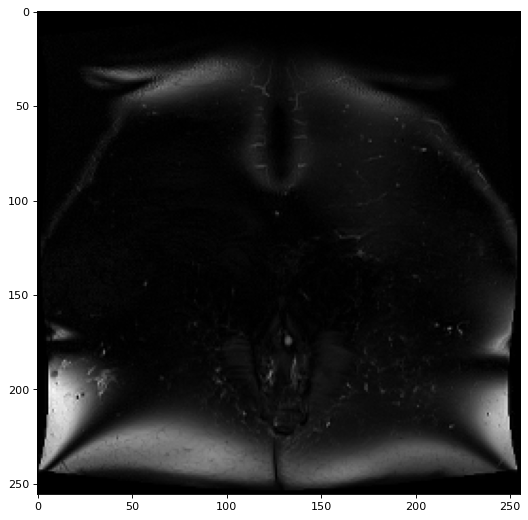

In [31]:
i = 38
figure(figsize=(8, 8), dpi=80)
image = single_image_list[i]['images']

imgplot = plt.imshow(image)
print(single_image_list[i]['label'])
print(single_image_list[i]['path'])

print(image.shape)
print(np.max(image))
print(np.min(image))

plt.show()

In [ ]:
means = []
stds = []
for img in subset(dataset):
    means.append(torch.mean(img))
    stds.append(torch.std(img))

mean = torch.mean(torch.tensor(means))
std = torch.mean(torch.tensor(stds))

In [20]:
class MRDatasetTypes(data.Dataset):

    def __init__(self,  ):
        super().__init__()
        
      
        self.data = single_image_list
        self.train = True
        self.length = len(single_image_list)
        self.transform = transform
        
        if self.train:
            pass
        else:
            self.transform = False

        if self.transform:
            

            self.transforms_random = A.Compose([
                A.HorizontalFlip(),
                A.RandomCrop(224, 224),
                A.Rotate(limit=5),
                
                #A.CLAHE(),
                A.GaussNoise(var_limit=(0.0, 30.0)),
                A.MedianBlur(blur_limit=3),
                #A.ElasticTransform(alpha=1, sigma=50),
                A.RandomGamma(gamma_limit=(60, 140)),
                #A.RandomFog(fog_coef_lower=0.0, fog_coef_upper=0.3)
            ])       

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):  
        
        array = self.data[index]['images']
        array = normalize_images_v1(array)
        label = self.data[index]['label']       
        if label == "SC":
            label = torch.FloatTensor([[0, 0, 0, 0, 0, 0, 1]])
        elif label == "BC":
            label = torch.FloatTensor([[0, 0, 0, 0, 0, 1, 0]])
        elif label == "BA":
            label = torch.FloatTensor([[0, 0, 0, 0, 1, 0, 0]])
        elif label == "SA":
            label = torch.FloatTensor([[0, 0, 0, 1, 0, 0, 0]])
        elif label == "SpC":
            label = torch.FloatTensor([[0, 0, 1, 0, 0, 0, 0]])
        elif label == "SpS":
            label = torch.FloatTensor([[0, 1, 0, 0, 0, 0, 0]])
        elif label == "REST":
            label = torch.FloatTensor([[0, 1, 0 ,0, 0, 0, 0]])
        elif label == "S":
            label = torch.FloatTensor([[1, 0 ,0, 0, 0, 0, 0]])
        elif label == "SS":
            label = torch.FloatTensor([[1, 0 ,0, 0, 0, 0, 0]])
        else:
            label = torch.FloatTensor([[0, 1, 0 ,0, 0, 0, 0]]) 
        

        if self.transform:
            array = self.make_random_transforms(array, self.transforms_random)
        else:
            array = torch.from_numpy(array)

        return array, label, 1

    def make_random_transforms(self, image, random_transforms):       
        transformed = random_transforms(image=image)
        image = np.moveaxis(transformed["image"], -1, 0)
        return image

In [29]:
def train_model(model, train_loader, epoch, num_epochs, optimizer, current_lr, log_every = 60, batch_size = 1):
    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()
    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, _) in enumerate(train_loader):

       
        
   
        optimizer.zero_grad()
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            # weight = weight.cuda()

        label = torch.squeeze(label) 
        #print(label[0].cpu())      
        #figure(figsize=(8, 8), dpi=80)
        #imgplot = plt.imshow(image[0,0,:,:].cpu())
        #plt.show()
        prediction = model.forward(image.float())
        loss = torch.nn.BCEWithLogitsLoss()(prediction, label)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)
        probas = torch.sigmoid(prediction)
        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        if i >= 2:
            threshold = 0.5
            #threshold = np.mean(np.array(y_preds))
            acc = metrics.accuracy_score(y_trues, preprocessing.binarize(np.array(y_preds).reshape(-1, 1), threshold=threshold))
            acc = np.round(acc, 4)
        else:
            
            acc = '-'


        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Batch number : {2} / {3} ]| avg train loss {4} | train auc : {5} acc: {6} | lr : {7}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      acc,
                      current_lr
                  )
                  )

    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    train_acc_epoch = acc
    return train_loss_epoch, train_auc_epoch, train_acc_epoch


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def run(lr_scheduler ='step',gamma = 0.5,epochs = 500,lr = 3e-6,
    log_every = 60, load_path = None, batch_size = 1):
    file_name = 'types_classifier_rnx.pth'
    best_acc = 0.90
    now = datetime.now()
    train_dataset = MRDatasetTypes()
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
    
    

    mrnet = model.ResNext()


    if load_path != None:
        mrnet.load_state_dict(torch.load(load_path))

    if torch.cuda.is_available():
        mrnet = mrnet.cuda()

    optimizer = optim.Adam(mrnet.parameters(), lr=lr, weight_decay=0.1)

    if lr_scheduler == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=3, gamma=gamma)

    
   
    num_epochs = epochs
    iteration_change_loss = 0
   

    t_start_training = time.time()
    epoch_delta = 0
    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)
        epoch_delta +=1
        t_start = time.time()
        
        train_loss, train_auc, train_acc = train_model(
            mrnet, train_loader, epoch, num_epochs, optimizer, current_lr, log_every, batch_size)
        if lr_scheduler == 'step':
            scheduler.step()

        t_end = time.time()
        delta = t_end - t_start

        print("train loss : {0} | train auc {1}  train acc {2}|  elapsed time {3} s".format(
            train_loss, train_auc, train_acc, delta))
        iteration_change_loss += 1
        print('-' * 30)
        if train_acc > best_acc:        
            torch.save(mrnet.state_dict(), f'./models/{epoch}_{file_name}')
            
    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')

transform_flag = True
resize_flag = True

run(lr_scheduler ='step',gamma = 0.88,epochs = 1000,lr = 3e-6,
    log_every = 5, load_path = None, batch_size = 42)

KeyboardInterrupt: 

S


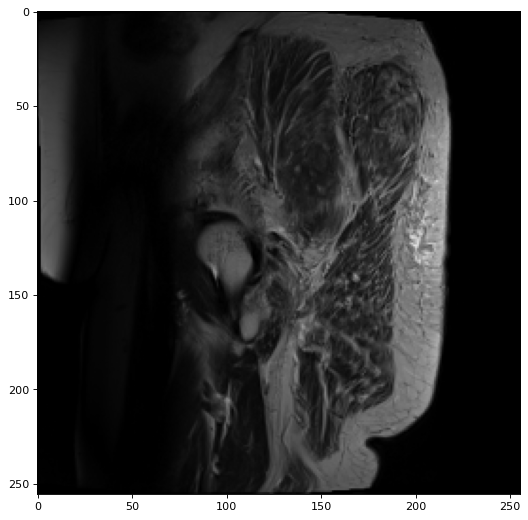

tensor([0.4146, 0.4114, 0.4059, 0.4140, 0.4337, 0.4655, 0.5012],
       grad_fn=<SigmoidBackward>)

In [25]:
import random 

PATH = 'models/4_types_classifier_rnx.pth'

item = random.choice(single_image_list)

print(item['label'])      
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(item['images'])
plt.show()

image = np.moveaxis(item['images'], -1, 0)
image = torch.tensor(np.expand_dims(image, axis=0)) 

#mrnet = model.MobileNetV3()
mrnet = model.ResNext()

mrnet.load_state_dict(torch.load(PATH))
mrnet.eval()

prediction = mrnet.forward(image.float())
sig = torch.nn.Sigmoid()
sig(prediction)